# Multiple Linear Regression to Predict the prices of cars:

Implemented by Pratham Shah

## Step 1: Imports and Cleaning the training/testing data.

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#reading the training and testing data
do = pd.read_csv("Train.csv")
test_do = pd.read_csv("Test.csv")

#tdata and testdata are lists of data (all feature's numeric values for a particular row in the dataset)
tdata = []
data = []

#exclues sr no and price. needed_titles are used to fill up tdata/data.
needed_titles = list(do)[1:-1]

#training prices = prices, testing prices = tprices
prices = do['Price']
tprices = test_do['Price']

#test_df and df are copies of test_do and do. I'm modifying these without touching test_do and do.
test_df = test_do.copy()
df = do.copy()

#To implement one hot encoding using pandas, for the names of the cars, im using only the brand names of the cars. This code does that.
for index, name in enumerate(df["Name"]):
    df.loc[index, "Name"] = str(df.loc[index, "Name"]).lower().split(" ")[0]
for index, name in enumerate(test_df["Name"]):
    test_df.loc[index, "Name"] = str(test_df.loc[index, "Name"]).lower().split(" ")[0]

#implementing one hot encoding using pandas.get_dummies for the columns where one hot encoding is needed
test_df = pd.get_dummies(test_df[needed_titles], columns = ["Name", "Location", "Fuel_Type" , "Transmission", "Owner_Type", "Year"], dtype=int)
df = pd.get_dummies(df[needed_titles], columns = ["Name", "Location", "Fuel_Type" , "Transmission", "Owner_Type", "Year"], dtype=int)

#This converts all numeric data stored as strings in the dataset into corresponding numbers only (eg. "80 kmpl" -> 80). null values converted to -1, to be removed later (eg. "null bhp" -> -1).
for index, vals in df.iterrows():
    vals.Engine = float(str(vals["Engine"]).replace(" CC", ""))
    vals.Mileage = float(str(vals["Mileage"]).replace(" kmpl", ""))
    vals.Power = float(str(vals["Power"]).replace(" bhp", "").replace("null", "-1"))

for tindex, tvals in test_df.iterrows():
    tvals.Engine = float(str(tvals["Engine"]).replace(" CC", ""))
    tvals.Mileage = float(str(tvals["Mileage"]).replace(" kmpl", ""))
    tvals.Power = float(str(tvals["Power"]).replace(" bhp", "").replace("null", "-1"))


#one hot encoding creates multiple new columns, depending on unique values in the dataset.
#training and testing datasets may not have exactly the same number of unique values.
#this adds missing columns to the datasets, so that they can have exactly the same no. of columns.
test_df_titles = list(test_df) #titles of testing dataframe
df_titles = list(df) #titles of training dataframe
for index, value in enumerate(df_titles):
    if test_df_titles.count(value) == 0:
        test_df.insert(index, value, list(0 for val in range(0, len(test_df))), True)
for index, value in enumerate(test_df_titles):
    if df_titles.count(value) == 0:
        df.insert(index, value, list(0 for val in range(0, len(df))), True)

#Above, I converted all null values to -1. This code removes all training/testing examples containing such a -1 from df/test_df
#The goal is to ensure that no 'null' valued training example is used to train the model.
for index, value in df.iterrows():
    if(df["Power"][index] == -1):
        df.drop(index, inplace=True)
        prices.drop(index=index, inplace=True)
for index, value in test_df.iterrows():
    if(test_df["Power"][index] == -1):
        test_df.drop(index, inplace=True)
        tprices.drop(index=index, inplace=True)

#data and tdata store the df and test_df's feature values for all the training examples as a list.
#this is a 2D list (mxn) where m = valid training examples and n = no. of columns in the feature dataset.
#data can be visualised as [[0, 0, 1, 0, 89.5, .. n features numerical values], [n numerical values], .... m valid training examples]
data = df.values.tolist()
tdata = test_df.values.tolist()

#checks if the data is organised enough to perform multiple regression.
#checks if the training and testing dataframes have the same number of feature columns
#checks if all features dataframes have a corresponding price
if len(data[0]) == len(tdata[0]) and len(prices) == len(data):
    print(f"PARSING SUCESSFUL ({len(data[0])} feature columns)  " * 3)
    if(len(do)-len(df) != 0):
        print(f"CAUTION: {len(do) - len(df)} examples dropped from training set, {len(test_do)-len(test_df)} examples dropped from testing set. (null value encountered)")
else:
    print(" WARNING: PARSING FAILURE " * 5)

PARSING SUCESSFUL (75 feature columns)  PARSING SUCESSFUL (75 feature columns)  PARSING SUCESSFUL (75 feature columns)  


## Step 2: Defining the functions to use for Multiple Linear Regression.

In [ ]:

def z_score_normalise(X):
    #Z score normalisation algorithm. Returns z score normalised dataset, means and std. deviations of the features.
    # find the mean of each n columns
    means     = np.mean(X, axis=0)                 # mean will have length n
    # find the standard deviation of each n columns
    stdevs  = np.std(X, axis=0)+0.00001                 # sigma will have length n. +0.00001 to prevent divide by 0 error.
    X_norm = (X - means) / stdevs    

    return (X_norm, means, stdevs)

def get_predictions(testing, weights, bias, correctvals):
  #returns predictions and their corresponding errors.
  #predict output value using test data multiplied by corresponding weights, + bias
  predictions = [np.dot(val, weights) + bias for val in testing]
  i = 0
  errs = []
  r2_numerator = 0
  r2_denominator = 0
  #mean of the correct values, for calculating r2 score.
  correct_avg = sum(correctvals)/len(correctvals)
  for value in predictions:
    #append error in prediction
    errs.append(value - correctvals[i])
    r2_numerator += math.pow(correctvals[i] - value,2) #calculates r2 numerator
    r2_denominator += math.pow(correctvals[i]- correct_avg, 2) #calculates r2 denominator
    i += 1 #looping variable
  mse = sum([err*err for err in errs])/len(errs) #mean squared error
  rmse = math.sqrt(mse) #root mean squared error
  return predictions, mse, rmse, 1 - r2_numerator/r2_denominator

def calculate_cost(X, y, w, b):
    m = X.shape[0] #stores number of training examples (m), to iterate through them
    cost = 0.0
    for i in range(m):                                      #iterates through training examples                            
        value_using_given_params = np.dot(X[i], w) + b      #stores the predicted value of the data, using provided weights and bias
        cost = cost + (value_using_given_params - y[i])**2  #calculates the 'sigma' part of the cost function 
    cost = cost / (2 * m)                                   #1/2m * sigma part = complete cost value          
    return cost

def calculate_gradient(X, y, w, b):
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0
    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i] #calculates error between actual and predicted value
        for j in range(n):                          
            dj_dw[j] = dj_dw[j] - err * X[i, j]    
        dj_db = dj_db - err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
    return dj_db, dj_dw #returns derivate of cost function wrt bias and weights

def gradient_descent(X, y, w_init, b_init, cost_function, gradient_function, alpha, num_iters):
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    errors = []
    w = w_init
    b = b_init
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)

        # Update Parameters using w, b, learning rate and gradient
        w = w - alpha * dj_dw            
        b = b - alpha * dj_db          
      
        # Save cost J at each iteration
        J_history.append( cost_function(X, y, w, b))

        if(i%100 == 0):
          predictions, mse, rmse, r2 = get_predictions(X_test, w, b, y_test)
          errors.append([mse, rmse, r2])
          print(f"At iteration {i} :\nCost Function:  {cost_function(X, y, w, b)}\nMSE: {mse}\nRMSE:  {rmse}\nR2:  {r2}\n")
        
    return w, b, J_history, errors #return final w,b and J history for graphing

def multiple_regression(xvals, yvals, initial_coeffs, initial_affine, iterations, learning_rate):
  w_final, b_final, J_hist, errhist = gradient_descent(xvals, yvals, initial_coeffs, initial_affine,
                                                      calculate_cost, calculate_gradient, 
                                                      learning_rate, iterations) #gets the final weights, bias and cost function history
  for index, value in enumerate(w_final):
     print(f"Weight of {list(df)[index]}  :   {value}")
  print(f"Bias value : {b_final}") #prints the weights and bias 
  return w_final, b_final, J_hist, errhist

## Step 3: Get the values and run the model.

In [3]:
X_train, feature_means, feature_stddevs = z_score_normalise(np.array(data)) #Z-score-normalise the training set, storing the features means and std devs for future reference.
y_train = np.array(prices) #stores training data's corresponding prices

y_test = np.array(tprices) #stores testing data prices
test_names = test_do["Name"] #stores names of cars in the testing data

b_init = 0
w_init = np.zeros_like(data[0]) #definind initial weights and biases
X_test = z_score_normalise(np.array(tdata))[0]

coeffs, affine, hist, errs = multiple_regression(X_train, y_train, np.zeros_like(w_init), 0, 15000, 0.001) #stores final weights, bias and cost function history

At iteration 0 :
Cost Function:  109.16476032787602
MSE: 220.02786878434105
RMSE:  14.83333640096998
R2:  -0.7705468291085651

At iteration 100 :
Cost Function:  76.78605463978911
MSE: 156.81925588920734
RMSE:  12.522749533916556
R2:  -0.2619121286401378

At iteration 200 :
Cost Function:  59.310838440933296
MSE: 122.74296152919113
RMSE:  11.07894225678567
R2:  0.012297112490277762

At iteration 300 :
Cost Function:  48.7109545649308
MSE: 102.04576862313748
RMSE:  10.101770568723953
R2:  0.1788457841368648

At iteration 400 :
Cost Function:  41.5679436553449
MSE: 88.04761407250999
RMSE:  9.383369015045181
R2:  0.2914878248470687

At iteration 500 :
Cost Function:  36.36099408286645
MSE: 77.79245482125476
RMSE:  8.820003107780336
R2:  0.3740102789099674

At iteration 600 :
Cost Function:  32.36636359285983
MSE: 69.8818306783957
RMSE:  8.35953531474063
R2:  0.43766644469384275

At iteration 700 :
Cost Function:  29.206326479463545
MSE: 63.589576221922876
RMSE:  7.974307256553567
R2:  0.4

## Step 4: Work with the generated results.

In [4]:
predictions, netmse, netrmse, netr2 = get_predictions(X_test, coeffs, affine, y_test) #stores the final predicitons, mean square error, root mse, and r2 score.
print(f"NET REGRESSION STATISTICS:\nFinal Cost Function: {hist[-1]}\nMean Square Error: {netmse}\nRoot Mean Square Error: {netrmse}\nR2 value: {netr2}")
print("*" * 60) #prints the regression statistics
for index, prediction in enumerate(predictions):
  print(f"{test_names[index]}:\nGiven Value:  {y_test[index]}\nPredicted Value: {predictions[index]}\nError:  {(abs(predictions[index]/y_test[index])-1)*100:8.2f}%\n") #prints predictions
#individually prints the actual price, predicted price and error between them for each car in the testing dataset.

NET REGRESSION STATISTICS:
Final Cost Function: 14.138042966035439
Mean Square Error: 31.35438046867751
Root Mean Square Error: 5.599498233652503
R2 value: 0.7476937843183284
************************************************************
Maruti Swift Dzire VDI:
Given Value:  6.95
Predicted Value: 5.186083945534576
Error:    -25.38%

Hyundai i10 Sportz AT:
Given Value:  2.9
Predicted Value: 0.06173026303724072
Error:    -97.87%

Hyundai Elite i20 Sportz Plus:
Given Value:  6.28
Predicted Value: 6.756224350148955
Error:      7.58%

Volvo XC60 D5:
Given Value:  13.8
Predicted Value: 19.87175744824221
Error:     44.00%

Hyundai i10 Magna 1.2:
Given Value:  2.75
Predicted Value: 0.7576846484087376
Error:    -72.45%

Audi A6 2.7 TDI:
Given Value:  11.5
Predicted Value: 20.04759222761116
Error:     74.33%

Maruti Swift VXI:
Given Value:  5.1
Predicted Value: 5.606497799676353
Error:      9.93%

Ford Endeavour 3.2 Titanium AT 4X4:
Given Value:  35.5
Predicted Value: 26.428992576406557
Error:    

## Step 5: Graph the generated results.

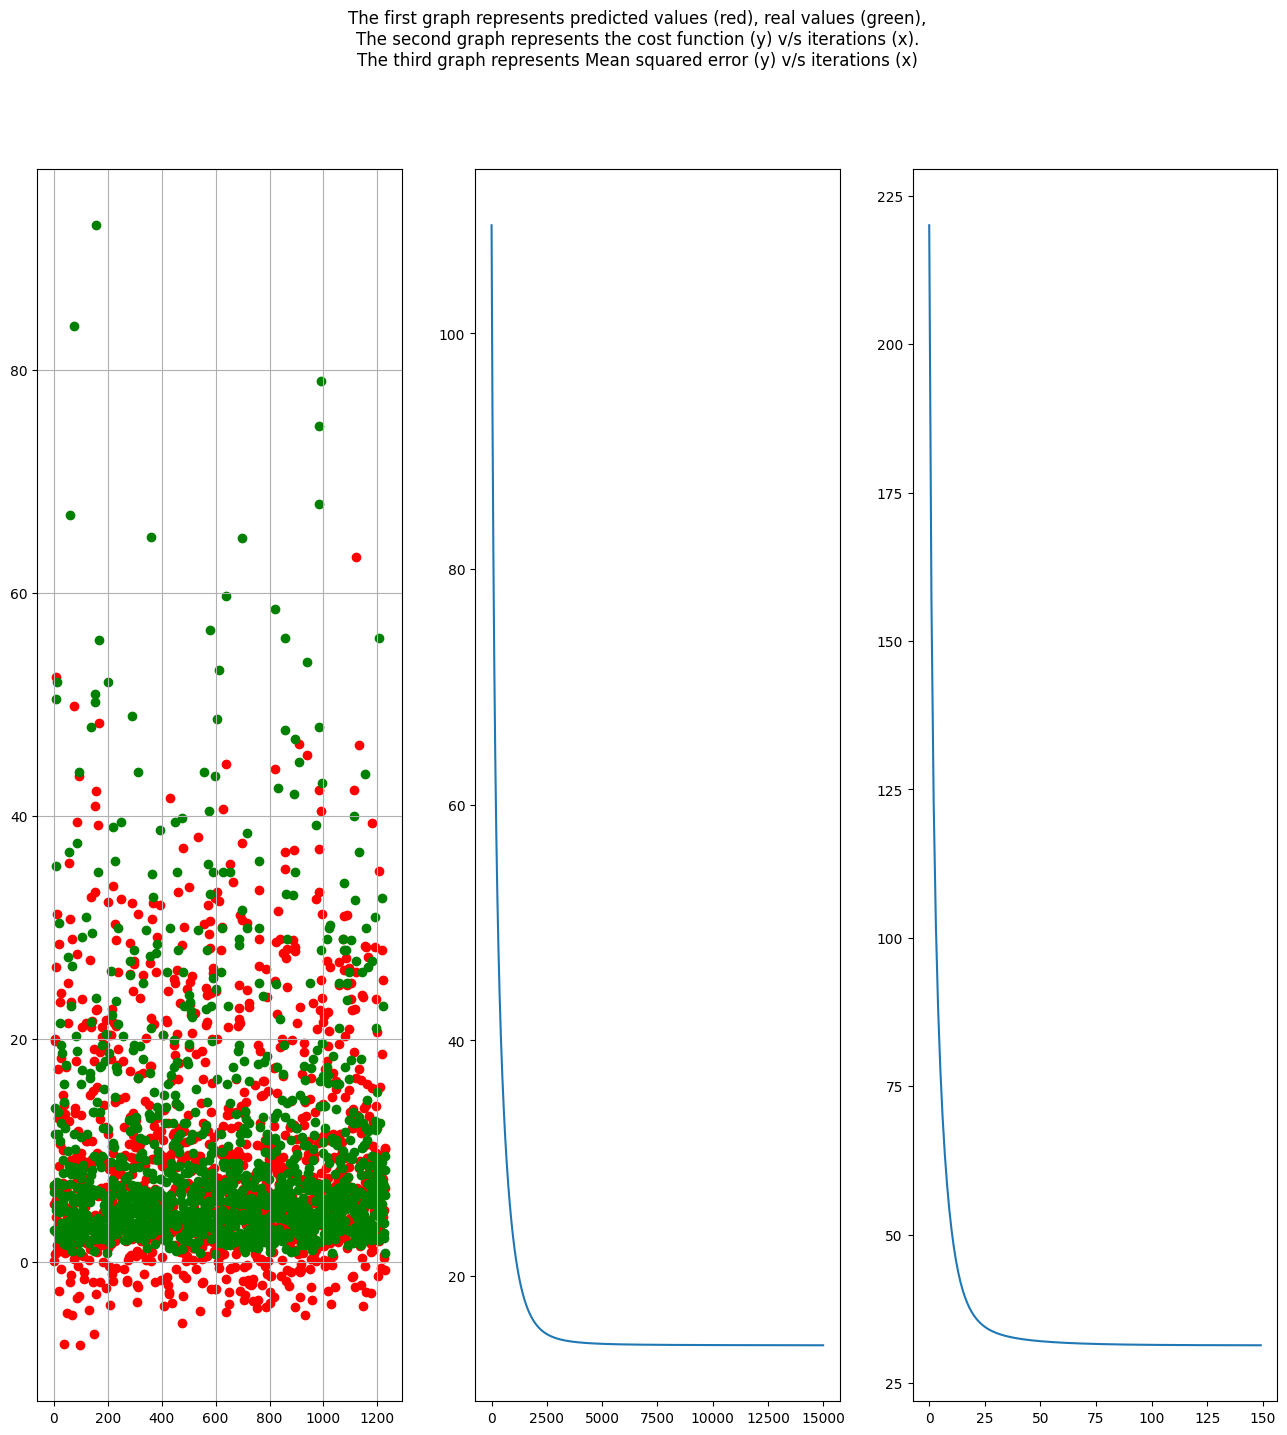

In [5]:
plt.rcParams['figure.figsize'] = [16, 16]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax2.plot(range(0, len(hist)), hist)     #plots the cost function v/s iterations
ax1.scatter(range(0, len(predictions)),predictions, c='r')  #plots the predicted values in red
ax1.scatter(range(0, len(y_test)),y_test, c='g')        #plots the actual values in green
ax1.grid()
ax3.plot(range(0, len(errs)), [err[0] for err in errs])
plt.suptitle("The first graph represents predicted values (red), real values (green),\nThe second graph represents the cost function (y) v/s iterations (x).\nThe third graph represents Mean squared error (y) v/s iterations (x)")
plt.show()

## Conclusion:

All features provided in the training sets have been incorporated into this model to increase its accuracy. 
I have implemented one hot encoding using Pandas for characterising the brands, years and locations of the vehicles and have fit them into the model. 
I have used string methods to convert certain numerical values into their corresponding numbers, and also to remove any training example with "null". 
Further, I have used z-score normalisation to ensure all features are fairly evaluated.

I have plotted the graph for cost function and mean square error v/s iterations. Error values (MSE, RMSE, R2) are also printed to the terminal after every 100 iterations. The final error after the model has been trained has also been printed.

After the model is trained, I have displayed the predicted weights and bias of the model for each feature column.
I have displayed the predicted and real price for every valid testing example in Test.csv, along with their corresponding error.
I have also graphed these values.

The multiple linear regression model thus generated provides a significant level of accuracy and can be use to efficiently predict the price of a car.
The MSE, RMSE and R2 scores appear to be well within the acceptable bounds of accuracy.
